### **House Price Prediction with MLFLOW**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# load the dataset
from sklearn.datasets import fetch_california_housing

# load the dataset
data = fetch_california_housing()

In [3]:
# create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
df["Price"] = data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### **Exploratory Data Analysis (EDA)**

In [5]:
# Perform EDA
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [6]:
# check for missing values
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Price         0
dtype: int64

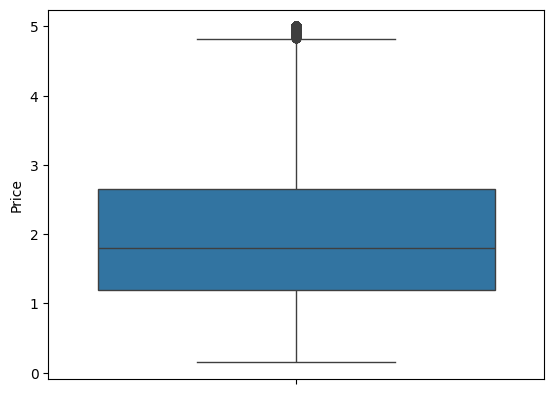

In [7]:
# Visualizations using seaborn
# plot the boxplot for target variable
sns.boxplot(df["Price"])
plt.show()


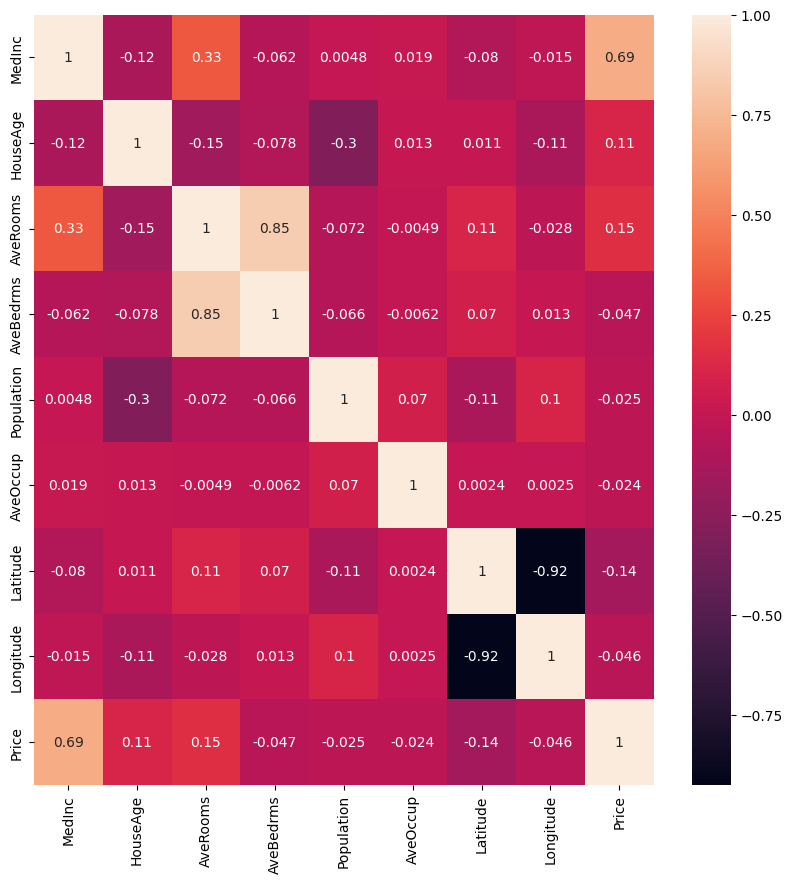

In [8]:
# plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

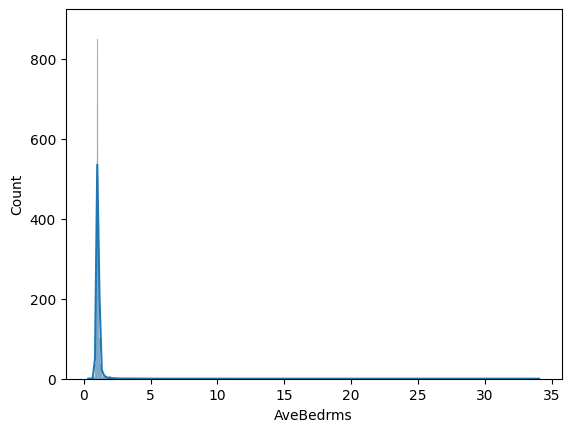

In [9]:
# histogram for number of bedrooms
sns.histplot(df["AveBedrms"], kde=True)
plt.show()

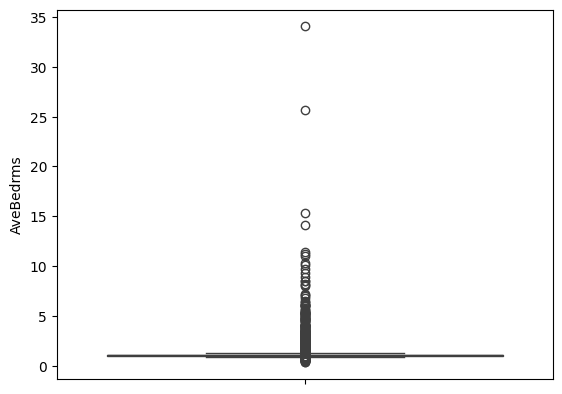

In [10]:
# boxplot for number of bedrooms
sns.boxplot(df["AveBedrms"])
plt.show()

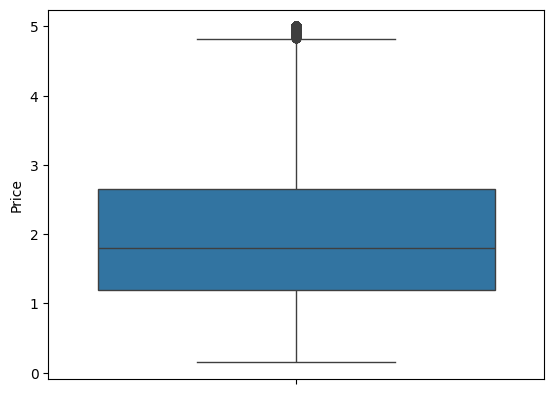

In [11]:
# boxplot for price
sns.boxplot(df["Price"])
plt.show()

### **Train ML Model and Log in to MLFLOW**

In [12]:
from urllib.parse import urlparse
#Independent and dependent variables
X = df.drop("Price", axis=1)
y = df["Price"]

In [13]:
# Hyperparaeter tuning using GridSearchCV
def hyperparameter_tuning(X_train, y_train, param_grid):
    # Create a RandomForestClassifier object
    rf = RandomForestRegressor()
    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                                cv = 3, n_jobs = -1, verbose = 2, 
                                scoring = 'neg_mean_squared_error')
    
    return grid_search.fit(X_train, y_train)

In [16]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from mlflow.models import infer_signature
signature = infer_signature(X_train, y_train)

# define hypermatameters for grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}


# Start an MLflow run
with mlflow.start_run():
    # Hyperparameter tuning
    grid_search = hyperparameter_tuning(X_train, y_train, param_grid)

    # Get the best model
    best_model = grid_search.best_estimator_
    # Predict the values
    y_pred = best_model.predict(X_test)

    # Log the metrics
    mlflow.log_metric("Mean Absolute Error", mean_absolute_error(y_test, y_pred))
    mlflow.log_metric("Mean Squared Error", mean_squared_error(y_test, y_pred))
    mlflow.log_metric("R2 Score", r2_score(y_test, y_pred))
    # Log the params
    mlflow.log_params(grid_search.best_params_)
    # Log the best score
    mlflow.log_metric("Best Score", grid_search.best_score_)

 
    # Set Tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Register the model
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(best_model, "best-model", signature=signature, registered_model_name="best-rf-model")
    else:
        mlflow.sklearn.log_model(best_model, "best-model", signature=signature)

    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)
    print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
    print("R2 Score: ", r2_score(y_test, y_pred))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


Registered model 'best-rf-model' already exists. Creating a new version of this model...
2025/01/03 11:00:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: best-rf-model, version 3


Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Score:  -0.26392819451064947
Mean Absolute Error:  0.3259244197696565
Mean Squared Error:  0.2531632363312657
R2 Score:  0.8068059357536503
🏃 View run skillful-kite-196 at: http://127.0.0.1:5000/#/experiments/0/runs/7e482e41d7374b31bbaf01cbeadb9521
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Created version '3' of model 'best-rf-model'.
